In [3]:
#! git clone https://github.com/Mertkaann/Palm-Fiction.git

In [4]:
import os
import random

In [5]:
curr_path = os.getcwd()
dataset = os.path.join(curr_path,"annotated_frames","cam1")
bounding_boxes = os.path.join(curr_path,"bounding_boxes","cam1")
joints_path = os.path.join(curr_path,"projections_2d","cam1")

dataset,bounding_boxes,joints_path

('/home/kaan/Desktop/Python/inzva/Palm-Fiction/annotated_frames/cam1',
 '/home/kaan/Desktop/Python/inzva/Palm-Fiction/bounding_boxes/cam1',
 '/home/kaan/Desktop/Python/inzva/Palm-Fiction/projections_2d/cam1')

In [6]:
!pwd

/home/kaan/Desktop/Python/inzva/Palm-Fiction


# Data Visualization

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np

In [9]:
def get_dataset_urls():
    return [url for url in os.listdir(dataset)]

In [10]:
def get_bound(path):
  with open(path, 'r') as reader:
    bounds = reader.readlines()
    bounds = [bound.split(' ')[1] for bound in bounds]

  bounds = [int(i) for i in bounds]
  #print("top, left, bottom, right")
  #print(bounds)

  bound_list = [['top_left',bounds[1],bounds[0]],
                ['top_right',bounds[3],bounds[0]],
                ['bottom_left',bounds[1],bounds[2]],
                ['bottom_right',bounds[3],bounds[2]]]
  #row_list.append(bound_list)

  bound_df = pd.DataFrame(bound_list,columns=["name","x","y"])
  bound_df.set_index('name',inplace=True)
  return bound_df

In [11]:
def get_bound_width_heght(bound):
  width = bound.loc['top_right']['x'] - bound.loc['top_left']['x']
  height =  bound.loc['bottom_left']['y'] - bound.loc['top_left']['y']
  return width,height

In [12]:
def get_joints(path):
  with open(path, 'r') as reader:
    joints = reader.readlines()
    joints = [joint.split(' ') for joint in joints]
  for joint in joints:
    joint[1] = float(joint[1])
    joint[2] = float(joint[2])
  joints = pd.DataFrame(joints,columns=["name","x","y"])
  return joints


In [13]:
def get_img(path):
  img = plt.imread(path)
  return img

In [14]:
def get_item(index):
  if index == -1:
    index = random.randint(0,600)
  sample_img = os.path.join(dataset,str(index)+"_webcam_1.jpg")
  sample_joints = os.path.join(joints_path,str(index)+"_jointsCam_1.txt")
  sample_bound = os.path.join(bounding_boxes,str(index)+"_bbox_1.txt")
  #print(index)
  #===============================================================#
  img = get_img(sample_img)
  #===============================================================#
  joints = get_joints(sample_joints)
  #===============================================================#
  bound_df = get_bound(sample_bound)
  #===============================================================#
  return img,joints,bound_df

In [15]:
def plot_everything(img,joints,bound):
  plt.imshow(img)
  plt.scatter(joints['x'],joints['y'])
  plt.scatter(bound['x'], bound['y'])

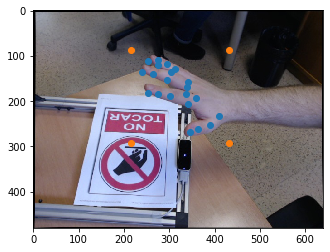

In [16]:
img,joints,bound = get_item(-1)
plot_everything(img,joints,bound)


# Data Preprocessing

In [17]:
import cv2

In [18]:
def crop_img(img,joints,bound):
  cropped_img = img[bound.loc['top_left']['y']:bound.loc['bottom_left']['y'],bound.loc['top_left']['x']:bound.loc['top_right']['x']]
  joints['x'] = joints['x']-bound.loc['top_left']['x']
  joints['y'] = joints['y']-bound.loc['top_left']['y']
  bound['x'] = bound['x']-bound.loc['top_left']['x']
  bound['y'] = bound['y']-bound.loc['top_left']['y']
  return cropped_img,joints,bound


In [19]:
def pad_img(img,bound,max_width,max_height):
  width,height = get_bound_width_heght(bound)
  top = left = 0
  bottom = max_width - height
  right = max_width - width
  padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 1)
  return padded_img

In [36]:
def train_test_split(test_size=0.2):
    urls = get_dataset_urls()

    np.random.shuffle(urls)
    
    slc = int(len(urls)*test_size)
    train = urls[slc:]
    test = urls[:slc]
    
    return train,test

708
708 708
['662_webcam_1.jpg', '443_webcam_1.jpg']


(480, 640, 3)

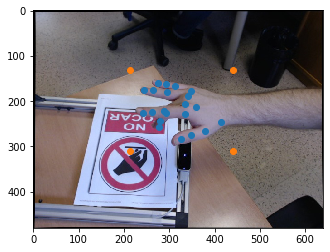

In [35]:
img,joints,bound = get_item(-1)
plot_everything(img,joints,bound)

img.shape

In [40]:
#Find Max height and width for hand images 
max_width= -1
max_height= -1

for f in os.listdir(bounding_boxes):
  bound_path = os.path.join(bounding_boxes,f)
  #index = f.split('_')[0]
  #img,joints,bound = get_item(index)
  bound = get_bound(bound_path)
  width,height = get_bound_width_heght(bound)
  #cropped_img,joints,bound = crop_img(img,joints,bound)
  #plot_everything(cropped_img,joints,bound)
  #print(cropped_img.shape)
  #print(cropped_img.shape[0]*cropped_img.shape[1],bound_area)
  if width > max_width:
    max_width = width
  if height > max_height:
    max_height = height
    with open('width_height.txt', 'w') as f:
      f.write("width,height")
      f.write(str(max_width) + ',' + str(max_height))
max_height,max_width

(257, 263)

In [23]:
Processed_imgs_Path = "./Processed_Imgs"
Processed_joints_Path = "./Processed_Joints"
Processed_bounds_Path = "./Processed_Bounds"

!mkdir ./Processed_Imgs
!mkdir ./Processed_Joints
!mkdir ./Processed_Bounds


mkdir: cannot create directory ‘./Processed_Imgs’: File exists
mkdir: cannot create directory ‘./Processed_Joints’: File exists
mkdir: cannot create directory ‘./Processed_Bounds’: File exists


In [24]:
from PIL import Image
from matplotlib import cm

In [25]:
for f in os.listdir(bounding_boxes):
  index = int(f.split('_')[0])
  img,joints,bound = get_item(index)

  cropped_img,joints,bound = crop_img(img,joints,bound)
  padded_img = pad_img(cropped_img,bound,max_width,max_height)
  print(f)
  joints.to_pickle(os.path.join(Processed_joints_Path,str(index)+".pkl"))
  bound.to_pickle(os.path.join(Processed_bound_Path,str(index)+".pkl"))
  plt.imsave(os.path.join(Processed_imgs_Path,str(index)+".jpg"), padded_img, cmap='Greys')
  #plot_everything(padded_img,joints,bound)
  #plt.show()


438_bbox_1.txt


NameError: name 'Processed_bound_Path' is not defined

In [ ]:
#!git config --global user.email "mert525kaan@gmail.com"
#!git config --global user.name "Mertkaann"

In [ ]:
#!rmdir Palm-Fiction/Padded_Imgs
#import shutil
#shutil.move(Padded_imgs_Path, "Palm-Fiction", copy_function = shutil.copytree)

In [ ]:
#%cd Palm-Fiction/
#!git add .
#!git status
#!git commit -m "Added Padded_Imgs as sub-directory"
#!git push origin

In [ ]:
#!git remote rm origin
#!git remote add origin 
#'git@github.com:Mertkaann/Palm-Fiction.git'

In [ ]:
#!pwd
#!git push -u origin master

In [ ]:
#%cd Palm-Fiction/
#!git add .
#!git status


In [ ]:
#!git commit -m "Added Padded_img"
#!git push origin
#!git remote add origin https://<username>:<password>github@github.com/<username>/reponame.git